In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
import operator
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix


import os
import settings

import Stemmer
import statsmodels.api as sm

In [37]:
def read_data():
    df = pd.read_excel(os.path.join(settings.PROCESSED_DIR, "all_with_liwc_segmented.xls"), encoding="ISO-8859-1")
    return df

In [38]:
df = read_data()

In [39]:
df['norm_inspiring'].describe()

count    2406.000000
mean      284.455193
std       275.047870
min         3.992689
25%       113.036934
50%       214.171009
75%       384.799377
max      6747.486017
Name: norm_inspiring, dtype: float64

In [40]:
views_median = df['norm_inspiring'].median()
views_upper_quantile = df['norm_inspiring'].quantile(.75)

In [41]:
df['inspiring_label'] = np.where(df['norm_inspiring'] >= views_median, 1, 0)

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
stemmer = SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [43]:
count_vect = StemmedCountVectorizer(analyzer="word", stop_words='english', min_df=2)
X_train_counts = count_vect.fit_transform(df['transcript'])
X_train_counts.shape

(2406, 20462)

In [44]:
sorted(count_vect.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)

[('î¾', 20461),
 ('éte', 20460),
 ('èé', 20459),
 ('èâthank', 20458),
 ('èâso', 20457),
 ('èâ', 20456),
 ('ève', 20455),
 ('èt', 20454),
 ('ès', 20453),
 ('ère', 20452),
 ('èm', 20451),
 ('èll', 20450),
 ('èd', 20449),
 ('ås', 20448),
 ('åres', 20447),
 ('åre', 20446),
 ('åme', 20445),
 ('àvet', 20444),
 ('àveli', 20443),
 ('àve', 20442),
 ('zx81', 20441),
 ('zurich', 20440),
 ('zulu', 20439),
 ('zuckerman', 20438),
 ('zuckerberg', 20437),
 ('zuccotti', 20436),
 ('zopa', 20435),
 ('zooplankton', 20434),
 ('zoop', 20433),
 ('zoonot', 20432),
 ('zoom', 20431),
 ('zoolog', 20430),
 ('zoo', 20429),
 ('zone', 20428),
 ('zombi', 20427),
 ('zoe', 20426),
 ('zodiac', 20425),
 ('zipper', 20424),
 ('ziploc', 20423),
 ('ziplin', 20422),
 ('zipcar', 20421),
 ('zip', 20420),
 ('zine', 20419),
 ('zinc', 20418),
 ('zimbardo', 20417),
 ('zimbabwean', 20416),
 ('zimbabw', 20415),
 ('zillion', 20414),
 ('zilch', 20413),
 ('zika', 20412),
 ('zigzag', 20411),
 ('zig', 20410),
 ('zheng', 20409),
 ('zf', 20

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2406, 20462)

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, df['inspiring_label'])

In [48]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)

In [49]:
predicted = clf.predict(X_test)
np.mean(predicted == y_test)

0.64784053156146182

In [50]:
clf.score(X_test, y_test)

0.64784053156146182

Classification accuracy is 68%

Null accuracy: accuracy that could be achieved by always predicting the most frequent class


In [51]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
max(y_test.mean(), 1 - y_test.mean())

0.5182724252491695

This means that a dumb model that always predicts 0 would be right 53% of the time

This shows how classification accuracy is fairly good as 15% higher than a dumb model
It's a good way to know the minimum we should achieve with our models

In [52]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

standard_confusion_matrix(y_test, predicted)

array([[264, 186],
       [ 26, 126]])

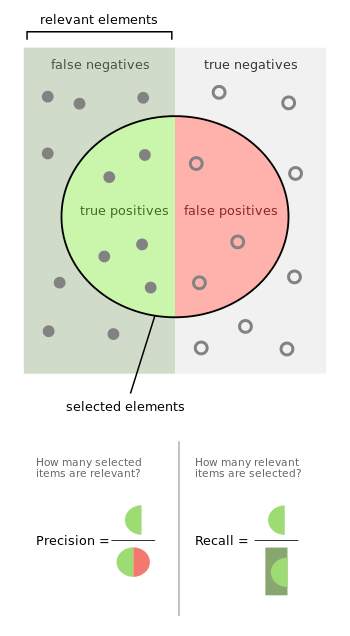

In [53]:
recall = recall_score(y_test, predicted)
recall

0.91034482758620694

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [54]:
precision = precision_score(y_test, predicted)
precision

0.58666666666666667

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

In [55]:
F1 = 2 * (precision * recall) / (precision + recall)
F1

0.71351351351351344

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

In [103]:
def show_most_informative_features(vectorizer, clf, n=100):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    top_words = []
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        top_words.append((coef_2, fn_2))
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
    top_words_df = pd.DataFrame(top_words, columns=['coefficient', 'word'])
    top_words_df.to_csv('top-words-inspiring.csv')
    return top_words_df

In [65]:
top_words_df = show_most_informative_features(count_vect,clf)

	-10.4036	000th          		-6.4844	peopl          
	-10.4036	004            		-6.6654	like           
	-10.4036	01             		-6.8153	just           
	-10.4036	02             		-6.8461	thing          
	-10.4036	040            		-6.8848	know           
	-10.4036	07             		-6.9150	year           
	-10.4036	08             		-6.9280	think          
	-10.4036	104            		-6.9771	go             
	-10.4036	112            		-6.9786	time           
	-10.4036	125th          		-6.9803	world          
	-10.4036	133            		-7.0078	want           
	-10.4036	139            		-7.0841	make           
	-10.4036	143            		-7.0946	work           
	-10.4036	1491           		-7.0954	said           
	-10.4036	1500           		-7.1081	ve             
	-10.4036	153            		-7.1391	say            
	-10.4036	161            		-7.1410	realli         
	-10.4036	1650           		-7.1632	way            
	-10.4036	167            		-7.1781	don            
	-10.4036	168            		-7.1

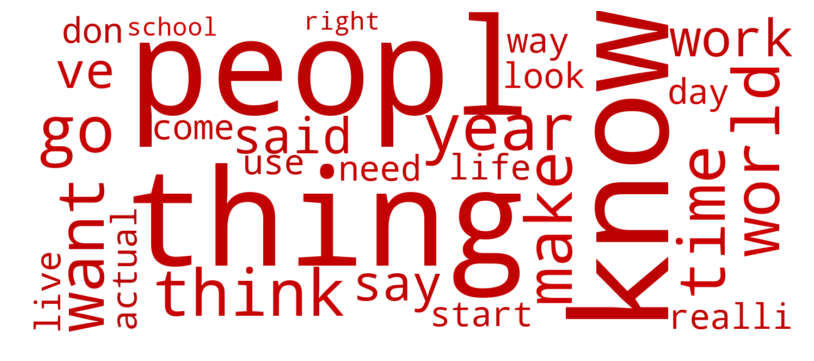

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
# Read the whole text.
text = top_words_df['word'].iloc[0:30].str.cat(sep=', ')

# Generate a word cloud image

wordcloud = WordCloud(width=1400, height=600, background_color='white').generate(text)

#change the value in return to set the single color need, in hsl format.
def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%%, %d%%)" % np.random.randint(37,41))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(14,6))
wordcloud.recolor(color_func = red_color_func)
plt.imshow(wordcloud, interpolation='bilinear')
#change the color setting
plt.axis("off")
#plt.savefig('Most Informative Features - Inspiring')
plt.show()


In [90]:
inspiring_df = pd.read_csv('top-words-inspiring.csv')
persuasive_df = pd.read_csv('top-words-persuasive.csv')
insp_set = set(inspiring_df['word'].iloc[0:100])
pers_set = set(persuasive_df['word'].iloc[0:100])

inspiring_unique = insp_set.difference(pers_set)
persuasive_unique = pers_set.difference(insp_set)

In [91]:
inspiring_unique
        

{'book',
 'came',
 'care',
 'famili',
 'girl',
 'home',
 'man',
 'old',
 'play',
 'student',
 'thought',
 'went'}

In [92]:
persuasive_unique

{'big',
 'brain',
 'compani',
 'data',
 'dollar',
 'exampl',
 'fact',
 'govern',
 'inform',
 'money',
 'number',
 'state'}

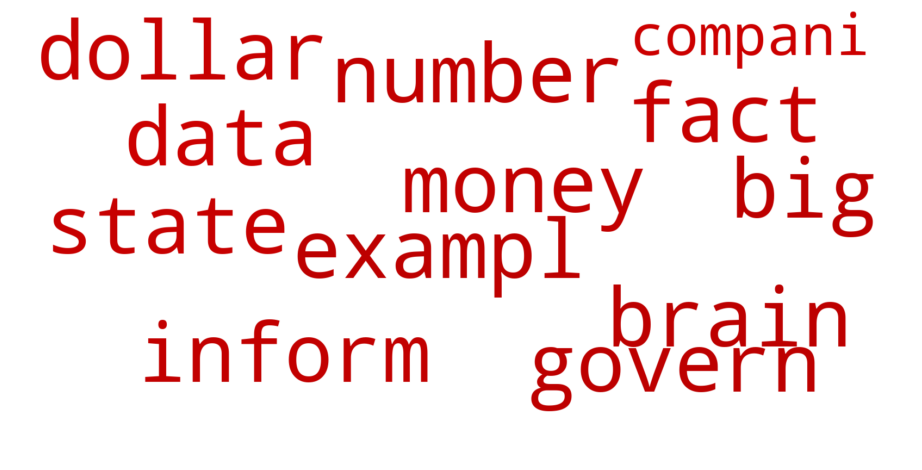

In [104]:
# Read the whole text.
text = ' '.join(persuasive_unique)

# Generate a word cloud image

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text)

#change the value in return to set the single color need, in hsl format.
def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%%, %d%%)" % np.random.randint(37,41))

# lower max_font_size
wordcloud = WordCloud(width=1600, height=800,background_color='white', max_font_size=150).generate(text)
plt.figure(figsize=(16,8))
wordcloud.recolor(color_func = red_color_func)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('Persuasive Unique Versus Inspiring in Top 100')
plt.show()

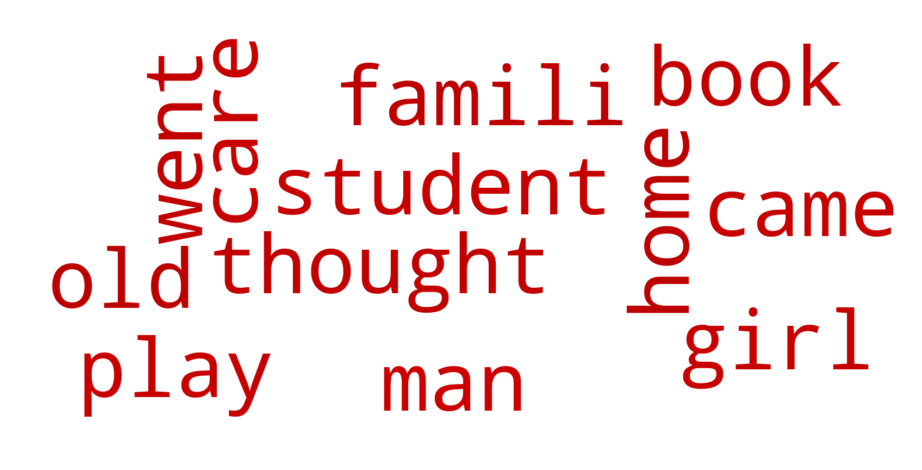

In [105]:
# Read the whole text.
text = ' '.join(inspiring_unique)

# Generate a word cloud image

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(text)

#change the value in return to set the single color need, in hsl format.
def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%%, %d%%)" % np.random.randint(37,41))

# lower max_font_size
wordcloud = WordCloud(width=1600, height=800,background_color='white', max_font_size=150).generate(text)
plt.figure(figsize=(16,8))
wordcloud.recolor(color_func = red_color_func)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('Inspiring Unique Versus Persuasive in Top 100')
plt.show()